In [1]:
from bs4 import BeautifulSoup
from newspaper import Article  # newspaper3k module
import requests
import pandas as pd

In [2]:
# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist


In [5]:
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


In [4]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [6]:
#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [7]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,모두에게 보여주고 싶은 기사라면?beta 이 기사를 추천합니다 버튼을 눌러주세요.\...,경제
5,"""요즘은 잔인한 날""…리프트도 앞서 982명 일시해고(뉴욕=연합뉴스) 이귀원 특파원...",경제
6,이재용 삼성전자 부회장(52)이 그룹 경영권 승계 과정에서 발생한 각종 불법·편법 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


In [8]:
from multiprocessing import Pool
import random
import time, os

def make_total_data(page_num, code_list, date):
  start = int(time.time())  
  num_cores = 4  
  df = None
  for code in code_list:
    pool = Pool(num_cores)
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')
    pool.close()
    pool.join()
    time.sleep(random.randint(0,1))
    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  print("***run time(sec) :", int(time.time()) - start)
  return df

In [10]:
code_list = [102, 103, 105]

In [11]:
df = make_total_data(1, code_list, 20200506)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
***run time(sec) : 26


In [12]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = '/home/evergrin/python/notebook/data/crawling/nv_news.dat'
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/home/evergrin/python/notebook/data/crawling/nv_news.dat File Saved!


In [13]:
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,[파주=파이낸셜뉴스 강근주 기자] 파주시는 4일 관내 취약계층 1만9379가구에 대...,사회
1,이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의 산소 공급 호스가...,사회
2,[의정부=파이낸셜뉴스 강근주 기자] 황범순 의정부시 부시장은 4일 시공 중인 을지대...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [15]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

In [16]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  53


<AxesSubplot:>

findfont: Font family [] not found. Falling back to DejaVu Sans.
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from current font.
  func(*args, **kwargs)
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  func(*args, **kwargs)
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  func(*args, **kwargs)
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAE

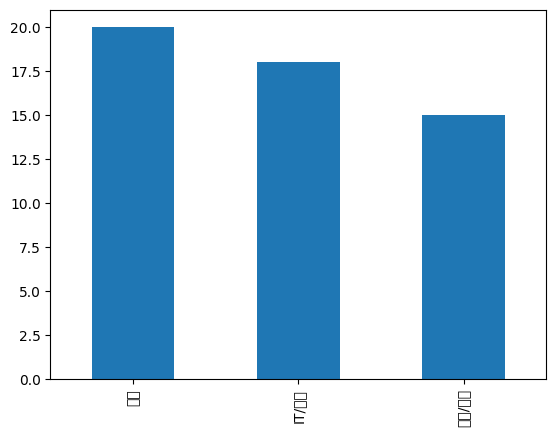

In [19]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [20]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학     18
1     사회     20
2  생활/문화     15


In [29]:
from konlpy.tag import Mecab, Okt, Komoran, Hannanum
# tokenizer = Mecab()

tokenizer = Hannanum()

JVMNotFoundException: No JVM shared library file (libjvm.so) found. Try setting up the JAVA_HOME environment variable properly.

In [21]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [23]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [ ]:
text_data = preprocessing(df['news'])
print(text_data[0])

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [ ]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

In [ ]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

In [ ]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))